<h1><center> AUTOMATIC TICKET CLASSIFICATION </center></h1>
<h4 align="right"> By Sindhu M, Sarat Shnakar and Shivani Raut </h4>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
# Filtering the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import swifter
from wordcloud import WordCloud, STOPWORDS

from collections import Counter
from nltk import word_tokenize, ngrams

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [4]:
#  Check the dataframe
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
#print the column names
print("Columns Names:\n", df.columns)

Columns Names:
 Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [7]:
#Assign new column names

# Define a function to remove the underscore and the first occurance source from the column names
def clean_name(col_name):
    col_name = col_name.replace('_', '', 1)
    col_name = col_name.replace('source.', '', 1)
    return col_name

# Apply the function to all column names
df.columns = [clean_name(col) for col in df.columns]

# Display the new column names
print("Columns Names:\n", df.columns)

Columns Names:
 Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [8]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)

# Checkiing first few rows
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [9]:
# Count the total number of Null Values
print("No. of records with Null complaints: ", df['complaint_what_happened'].isnull().sum())

No. of records with Null complaints:  57241


In [10]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

In [11]:
# Checking the dataframe shape 
print("Dataframe without Null (Shape):", df.shape)

Dataframe without Null (Shape): (21072, 22)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [13]:
# Apply data cleaning to the complaints_what_happened column
df['Complaints'] = df['complaint_what_happened'].apply(clean_text)

#Checking the dataframe
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,Complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...


In [14]:
#Write your function to Lemmatize the texts
def text_lemma(text):     
        lemma_list = []
        
        document = nlp(text)
        
        for word in document:
            lemma_list.append(word.lemma_)
            
        return " ".join(lemma_list)

In [15]:
# Apply data cleaning to the complaints_what_happened column
df['Complaint_Lemmatization'] = df['Complaints'].apply(text_lemma)

#Checking the dataframe
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,Complaints,Complaint_Lemmatization
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'Complaints':df['Complaints'], 'Lemmatized':df['Complaint_Lemmatization']})

In [17]:
pd.set_option('max_colwidth', 50)
df_clean

,Complaints,Lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [18]:
#Write your function to extract the POS tags 
def pos_tag(text):
  # write your code here
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["Complaint_POS_Removed"] =  df_clean.swifter.apply(lambda x: pos_tag(x['Lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,Complaints,Lemmatized,Complaint_POS_Removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




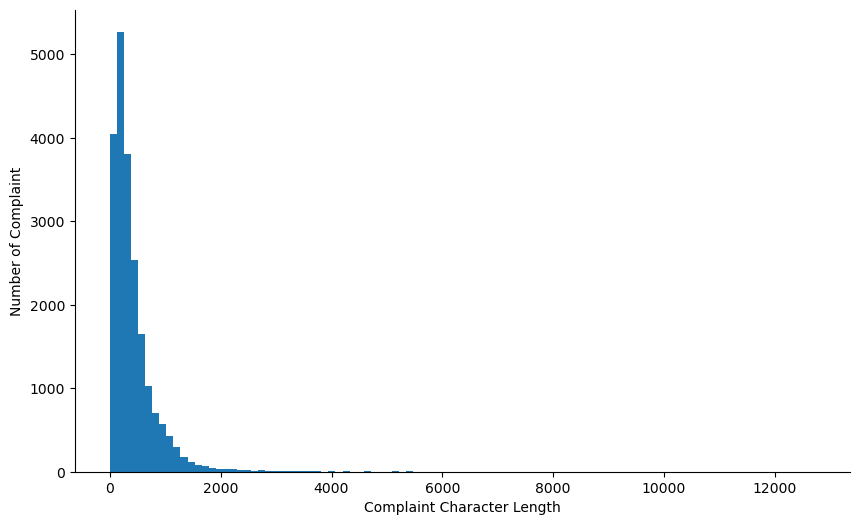

In [20]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.Complaint_POS_Removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint Character Length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

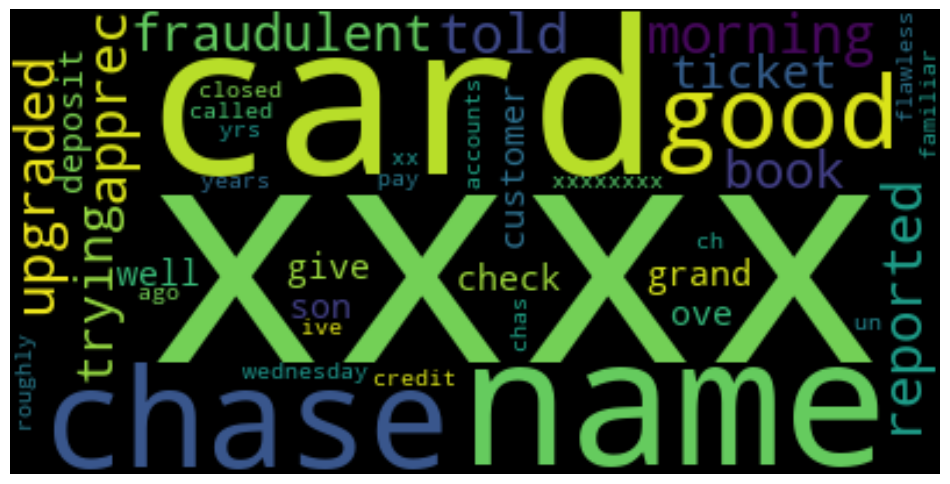

In [21]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
# Top 40 words frequency wise wordcloud in Complaints
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['Complaints']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

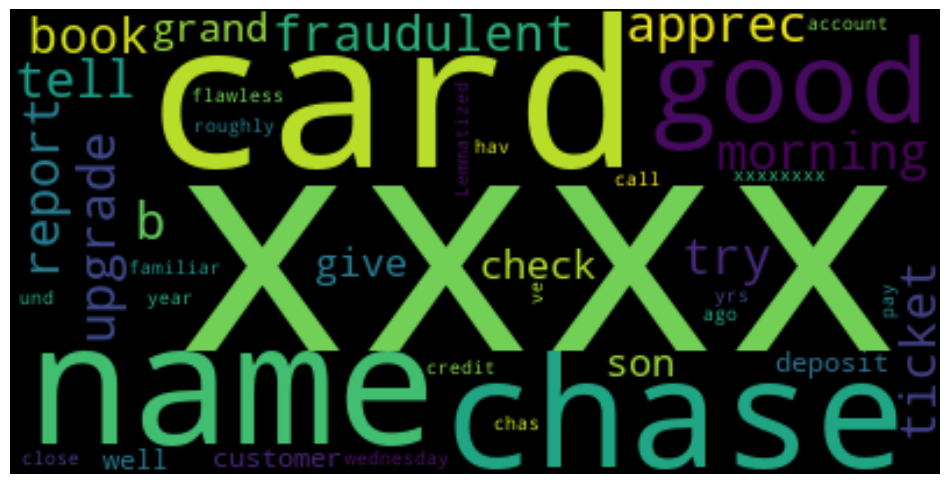

In [22]:
# Top 40 words frequency wise wordcloud in Lemmatized
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['Lemmatized']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

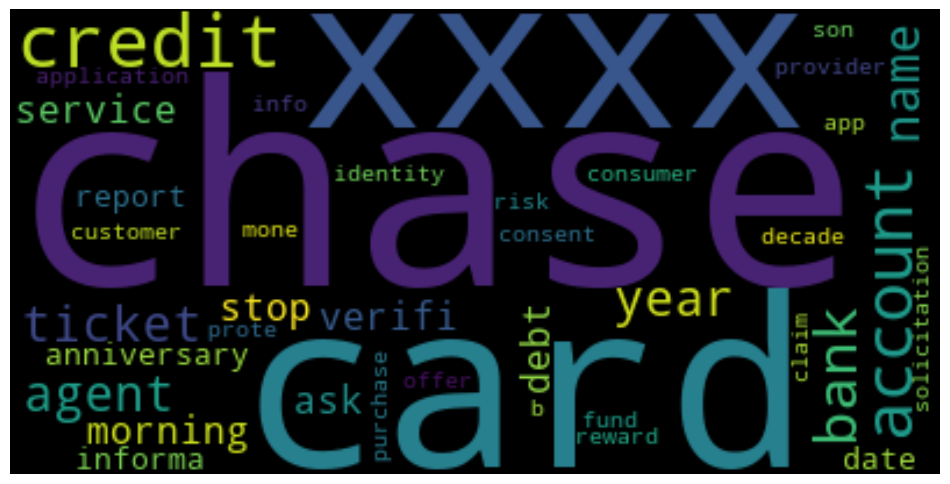

In [23]:
# Top 40 words frequency wise wordcloud in Complaint_POS_Removed
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['Complaint_POS_Removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [24]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['Complaint_POS_Removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
# Tokenize the complaints
tokens = df_clean['Complaint_clean'].str.split()

# Flatten the list of tokens
flat_tokens = [item for sublist in tokens for item in sublist]

# Count the frequency of each word
word_counts = Counter(flat_tokens)

# Get the top 30 unigrams
top_30_unigrams = word_counts.most_common(30)

# Print the top 30 unigrams
print("Top 30 Unigrams:")
for word, count in top_30_unigrams:
    print(f"{word}: {count}")

Top 30 Unigrams:
chase: 52745
xxxx: 48184
account: 46731
credit: 33464
card: 30216
bank: 21613
payment: 21158
time: 16008
charge: 14153
xxxxxxxx: 13583
day: 12971
check: 12100
money: 11953
loan: 10899
information: 9644
letter: 9598
fee: 8890
report: 8855
number: 8614
transaction: 8564
month: 8461
amount: 8422
call: 8366
year: 8289
customer: 8137
mortgage: 8072
balance: 7759
service: 7698
phone: 7570
company: 7534


In [27]:
#Print the top 10 words in the unigram frequency
top_10_unigrams = word_counts.most_common(10)

# Print the top 10 unigrams
print("Top 10 Unigrams:")
for word, count in top_10_unigrams:
    print(f"{word}: {count}")

Top 10 Unigrams:
chase: 52745
xxxx: 48184
account: 46731
credit: 33464
card: 30216
bank: 21613
payment: 21158
time: 16008
charge: 14153
xxxxxxxx: 13583


In [28]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
# Tokenize the lemmatized complaints
tokenized_complaints = [complaint.split() for complaint in df_clean['Complaint_clean']]

# Generate bigrams from tokenized complaints
bigrams_list = [ngrams(tokens, 2) for tokens in tokenized_complaints]

# Flatten the list of bigrams
flattened_bigrams = [bigram for sublist in bigrams_list for bigram in sublist]

# Count the occurrences of each bigram
bigram_counts = Counter(flattened_bigrams)

# Get the top 30 bigrams
top_30_bigrams = bigram_counts.most_common(30)

# Print the top 30 bigrams
for bigram, count in top_30_bigrams:
    print(bigram, ":", count)

('credit', 'card') : 12841
('xxxx', 'xxxx') : 5012
('credit', 'report') : 3927
('customer', 'service') : 3058
('account', 'chase') : 2802
('chase', 'credit') : 2781
('chase', 'account') : 2521
('bank', 'account') : 2391
('check', 'account') : 2244
('account', 'account') : 2072
('chase', 'bank') : 2061
('debit', 'card') : 1965
('checking', 'account') : 1846
('chase', 'card') : 1728
('credit', 'score') : 1707
('account', 'xxxx') : 1686
('phone', 'call') : 1649
('number', 'xxxx') : 1636
('xxxx', 'credit') : 1616
('card', 'account') : 1608
('xxxx', 'chase') : 1597
('card', 'chase') : 1478
('xxxx', 'account') : 1410
('account', 'credit') : 1388
('chase', 'xxxx') : 1311
('interest', 'rate') : 1288
('business', 'day') : 1253
('money', 'account') : 1252
('account', 'bank') : 1241
('phone', 'number') : 1240


In [29]:
#Print the top 10 words in the bigram frequency
top_10_bigrams = bigram_counts.most_common(10)

# Print the top 10 bigrams
for bigram, count in top_10_bigrams:
    print(bigram, ":", count)

('credit', 'card') : 12841
('xxxx', 'xxxx') : 5012
('credit', 'report') : 3927
('customer', 'service') : 3058
('account', 'chase') : 2802
('chase', 'credit') : 2781
('chase', 'account') : 2521
('bank', 'account') : 2391
('check', 'account') : 2244
('account', 'account') : 2072


In [30]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).

# Tokenize the lemmatized complaints
tokenized_complaints = [complaint.split() for complaint in df_clean['Complaint_clean']]

# Generate trigrams from tokenized complaints
trigrams_list = [ngrams(tokens, 3) for tokens in tokenized_complaints]

# Flatten the list of trigrams
flattened_trigrams = [trigram for sublist in trigrams_list for trigram in sublist]

# Count the occurrences of each trigram
trigram_counts = Counter(flattened_trigrams)

# Get the top 30 trigrams
top_30_trigrams = trigram_counts.most_common(30)

# Print the top 30 trigrams
for trigram, count in top_30_trigrams:
    print(trigram, ":", count)

('chase', 'credit', 'card') : 1880
('credit', 'card', 'account') : 1066
('credit', 'card', 'company') : 981
('xxxx', 'credit', 'card') : 786
('xxxx', 'xxxx', 'xxxx') : 779
('credit', 'card', 'chase') : 683
('inquiry', 'credit', 'report') : 488
('credit', 'card', 'credit') : 478
('credit', 'card', 'xxxx') : 398
('account', 'credit', 'card') : 394
('chase', 'customer', 'service') : 385
('credit', 'reporting', 'agency') : 382
('charge', 'credit', 'card') : 372
('chase', 'checking', 'account') : 371
('card', 'credit', 'card') : 358
('credit', 'report', 'credit') : 346
('customer', 'service', 'representative') : 339
('credit', 'reporting', 'act') : 338
('credit', 'card', 'payment') : 293
('chase', 'bank', 'account') : 278
('credit', 'card', 'charge') : 269
('account', 'number', 'xxxx') : 264
('account', 'credit', 'report') : 259
('bank', 'credit', 'card') : 256
('chase', 'card', 'service') : 255
('chase', 'auto', 'finance') : 253
('victim', 'identity', 'theft') : 251
('account', 'chase', 'a

In [31]:
# Get the top 10 trigrams
top_10_trigrams = trigram_counts.most_common(10)

# Print the top 10 trigrams
for trigram, count in top_10_trigrams:
    print(trigram, ":", count)

('chase', 'credit', 'card') : 1880
('credit', 'card', 'account') : 1066
('credit', 'card', 'company') : 981
('xxxx', 'credit', 'card') : 786
('xxxx', 'xxxx', 'xxxx') : 779
('credit', 'card', 'chase') : 683
('inquiry', 'credit', 'report') : 488
('credit', 'card', 'credit') : 478
('credit', 'card', 'xxxx') : 398
('account', 'credit', 'card') : 394


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [32]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [33]:
#All masked texts has been removed
df_clean

,Complaints,Lemmatized,Complaint_POS_Removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [34]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [35]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [36]:
dtm.shape

(21072, 6776)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [37]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [38]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [39]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6776

In [40]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,checking,number,business,transfer,transaction,customer
Topic 2,card,credit,chase,balance,account,limit,score,year,point,month,purchase,offer,application,service,time
Topic 3,payment,loan,mortgage,chase,home,month,modification,time,year,rate,property,balance,statement,date,letter
Topic 4,report,inquiry,credit,company,information,reporting,debt,identity,account,theft,score,letter,date,file,creditor
Topic 5,charge,dispute,transaction,chase,fee,merchant,claim,fraud,purchase,service,email,refund,time,company,day


In [41]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([0, 1, 3, ..., 4, 1, 2], dtype=int64)

In [42]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [43]:
df_clean.head(15)

,Complaints,Lemmatized,Complaint_POS_Removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,3
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,3
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,2
21,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,payment retailer chase pay xxxx chase website ...,payment retailer chase pay chase website scam...,4
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,credit card datum credit report company issue,credit card datum credit report company issue,3


In [44]:
#Print the first 5 Complaint for each of the Topics
pd.set_option('max_colwidth', 300)
Top_5=df_clean.groupby('Topic').head(5)
Top_5.sort_values('Topic')

,Complaints,Lemmatized,Complaint_POS_Removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail eve...,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account advance help,0
24,mishandling of this account by chase auto and xxxx,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,mishandle account chase auto,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually be close I go into the branch to see how I can remove the fund that be in there currently in as well...,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day branch fund post look account fund statement call business day state date fund bank teller chase inform check busi...,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day branch fund post look account fund statement call business day state date fund bank teller chase inform check busi...,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times t...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he...,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number xxxx chase,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number chase,0
27,i opened an account with chase bank on xxxx and used a code for xxxx bonus i called to follow up on xxxxxxxx about the terms and was told everything was on the account and once i made xxxx direct deposit the bonus would be paid out in days as of xxxx i had made the required deposits and was tol...,I open an account with chase bank on xxxx and use a code for xxxx bonus I call to follow up on xxxxxxxx about the term and be tell everything be on the account and once I make xxxx direct deposit the bonus would be pay out in day as of xxxx I have make the require deposit and be tell my accoun...,account bank code bonus xxxxxxxx term everything account xxxx deposit bonus day xxxx require deposit account coupon code day bonus,account bank code bonus

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [45]:
#Create the dictionary of Topic names and Topics
pd.set_option('max_colwidth', 50)

Topic_names = {0:'Bank Account Services', 1:'Credit card or prepaid card', 2:'Mortgage/Loan', 3:'Others', 4:'Theft/Dispute Reporting'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
df_clean

,Complaints,Lemmatized,Complaint_POS_Removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,Bank Account Services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,Others
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,Others
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank Account Services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...,Credit card or prepaid card


#### IMBALANCE CHECK

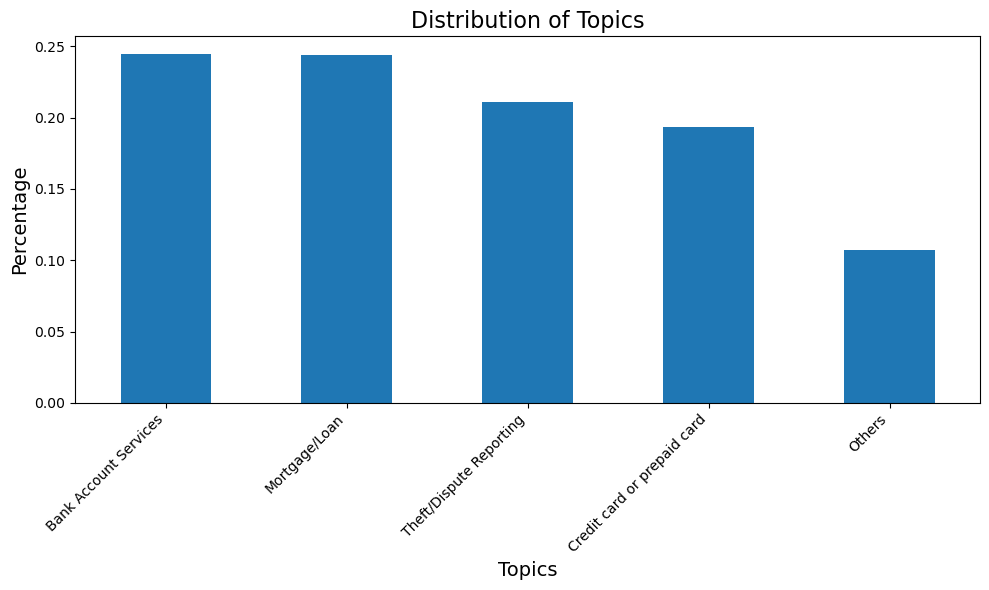

In [47]:
# Calculate the value count of topics
counts = df_clean.Topic.value_counts(normalize=True)

# Plot a bar graph
plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.title('Distribution of Topics', fontsize=16)
plt.xlabel('Topics', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [48]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Bank Account Services':0, 'Credit card or prepaid card':1, 'Mortgage/Loan':2, 'Others':3, 'Theft/Dispute Reporting':4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [49]:
df_clean

,Complaints,Lemmatized,Complaint_POS_Removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,3
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...,4
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...,4
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...,1


In [50]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean.drop(['Lemmatized', 'Complaint_POS_Removed', 'Complaint_clean'], axis=1)

In [51]:
training_data

,Complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,3
11,on while trying to book a xxxx xxxx ticket ...,3
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,4
78310,i am not familiar with xxxx pay and did not un...,4
78311,i have had flawless credit for yrs ive had ch...,1


In [52]:
# Calculate the value count of topics
training_data.Topic.value_counts()

0    5159
2    5144
4    4444
1    4070
3    2255
Name: Topic, dtype: int64

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [53]:
#Write your code to get the Vector count
count_vect = CountVectorizer(ngram_range=(1, 3),
                             stop_words='english',
                             max_df=0.95,
                             min_df=0.02)
X_train_counts = count_vect.fit_transform(training_data.Complaints)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

print(X_train_tfidf )

  (0, 803)	0.1641295428952789
  (0, 796)	0.24976328350146684
  (0, 777)	0.28970309380225717
  (0, 776)	0.18189657048099356
  (0, 748)	0.19444474511586154
  (0, 687)	0.15906737468636437
  (0, 681)	0.13124859507164477
  (0, 655)	0.14796176700596808
  (0, 650)	0.0977644717630956
  (0, 631)	0.13776243474185895
  (0, 579)	0.16051141269169225
  (0, 466)	0.17775776946478225
  (0, 460)	0.12156219919966128
  (0, 438)	0.13376391421656011
  (0, 397)	0.11372315705864855
  (0, 375)	0.14963595891798395
  (0, 368)	0.09768402757210219
  (0, 341)	0.2187859015518321
  (0, 331)	0.14405955069369586
  (0, 237)	0.4286915332466888
  (0, 188)	0.14525673941539227
  (0, 172)	0.19381665377555501
  (0, 132)	0.08777068198252264
  (0, 131)	0.16113538953780338
  (0, 130)	0.14020675857389583
  :	:
  (21071, 401)	0.18805002928443612
  (21071, 390)	0.1170129398130757
  (21071, 389)	0.11316262187651066
  (21071, 388)	0.11169503839034679
  (21071, 360)	0.09742995308392696
  (21071, 265)	0.12252630453198193
  (21071, 249)

In [54]:
# Checking X_train_tfidf shape
print(X_train_tfidf.shape)

(21072, 820)


In [55]:
# Checking X_train_counts array
print(X_train_counts.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 3 1 0]]


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

In [57]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42, stratify=training_data.Topic)

# Checking new dataframe shape
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16857, 820)
(4215, 820)
(16857,)
(4215,)


#### "Accuracy" is chosen as metric for evaluation, since this is a multi-class problem.

#### 1. Logistic Regression

In [58]:
# Logistic Regression

# Train the model
lr = LogisticRegression().fit(X_train, y_train)

# Predict the train and test set results
train_pred = lr.predict(X_train)
pred = lr.predict(X_test)

# Print the Confusion Matrix for the test set
print ("Confusion Matrix (Test):\n", confusion_matrix(y_test, pred))

print("-"*100)

# Print the Classification Report for the Train set
print("Evaluation metric report (Train):\n", classification_report(y_train, train_pred))

print("-"*100)

# Print the Classification Report for the Test set
print("Evaluation metric report (Test):\n", classification_report(y_test, pred))

Confusion Matrix (Test):
 [[975  10   7   7  33]
 [ 11 752   7  15  29]
 [ 14  15 968  11  21]
 [ 12  20  13 396  10]
 [ 30  19  21   5 814]]
----------------------------------------------------------------------------------------------------
Evaluation metric report (Train):
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      4127
           1       0.95      0.94      0.95      3256
           2       0.96      0.97      0.97      4115
           3       0.95      0.91      0.93      1804
           4       0.93      0.93      0.93      3555

    accuracy                           0.95     16857
   macro avg       0.95      0.94      0.95     16857
weighted avg       0.95      0.95      0.95     16857

----------------------------------------------------------------------------------------------------
Evaluation metric report (Test):
               precision    recall  f1-score   support

           0       0.94      0.94      0.94

#### 2. Decision Tree

In [59]:
# Decision tree classifier

# Train the model
dt = DecisionTreeClassifier().fit(X_train, y_train)

# Predict the train and test set results
train_pred = dt.predict(X_train)
pred = dt.predict(X_test)

# Print the Confusion Matrix for the test set
print ("Confusion Matrix (Test):\n", confusion_matrix(y_test, pred))

print("-"*100)

# Print the Classification Report for the test set
print("Evaluation metric report (Train):\n", classification_report(y_train, train_pred))

print("-"*100)

# Print the Classification Report for the test set
print("Evaluation metric report (Test):\n", classification_report(y_test, pred))

Confusion Matrix (Test):
 [[806  41  51  37  97]
 [ 32 628  24  42  88]
 [ 44  32 870  31  52]
 [ 31  46  42 309  23]
 [ 99  68  59  26 637]]
----------------------------------------------------------------------------------------------------
Evaluation metric report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4127
           1       1.00      1.00      1.00      3256
           2       1.00      1.00      1.00      4115
           3       1.00      1.00      1.00      1804
           4       1.00      1.00      1.00      3555

    accuracy                           1.00     16857
   macro avg       1.00      1.00      1.00     16857
weighted avg       1.00      1.00      1.00     16857

----------------------------------------------------------------------------------------------------
Evaluation metric report (Test):
               precision    recall  f1-score   support

           0       0.80      0.78      0.79

#### 3. Decision Tree (Hyper-parameter  Tuning)

In [60]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions and evaluate the model
train_pred =  best_model.predict(X_train)
pred =  best_model.predict(X_test)

# Print the Best parameters found
print(f"Best parameters found: {best_params}")

print("-"*100)

# Print the Confusion Matrix for the test set
print ("Confusion Matrix (Test):\n", confusion_matrix(y_test, pred))

print("-"*100)

# Print the Classification Report for the Train set
print("Evaluation metric report (Train):\n", classification_report(y_train, train_pred))

print("-"*100)

# Print the Classification Report for the Test set
print("Evaluation metric report (Test):\n", classification_report(y_test, pred))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
----------------------------------------------------------------------------------------------------
Confusion Matrix (Test):
 [[832  33  43  25  99]
 [ 31 661  15  38  69]
 [ 43  38 858  20  70]
 [ 31  52  29 318  21]
 [107  99  48  23 612]]
----------------------------------------------------------------------------------------------------
Evaluation metric report (Train):
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      4127
           1       0.90      0.94      0.92      3256
           2       0.95      0.92      0.93      4115
           3       0.92      0.86      0.89      1804
           4       0.86      0.85      0.86      3555

    accuracy                           0.91     16857
   macro avg       0.91      0.90      0.90 

#### 4. Random Forest

In [61]:
#Random Forest Classifer
# Initialize the RandomForestClassifier
rfc = RandomForestClassifier(random_state=40)

# Train the model
rfc.fit(X_train, y_train)

# Predict the train and test set results
train_pred = rfc.predict(X_train)
pred = rfc.predict(X_test)

# Print the Confusion Matrix for the test set
print ("Confusion Matrix (Test):\n", confusion_matrix(y_test, pred))

print("-"*100)

# Print the Classification Report for the Train set
print("Evaluation metric report (Train):\n", classification_report(y_train, train_pred))

print("-"*100)

# Print the Classification Report for the Test set
print("Evaluation metric report (Test):\n", classification_report(y_test, pred))

Confusion Matrix (Test):
 [[942  20  25   9  36]
 [ 20 720   5  17  52]
 [ 22  38 941  11  17]
 [ 19  36  30 355  11]
 [ 73  34  39   9 734]]
----------------------------------------------------------------------------------------------------
Evaluation metric report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4127
           1       1.00      1.00      1.00      3256
           2       1.00      1.00      1.00      4115
           3       1.00      1.00      1.00      1804
           4       1.00      1.00      1.00      3555

    accuracy                           1.00     16857
   macro avg       1.00      1.00      1.00     16857
weighted avg       1.00      1.00      1.00     16857

----------------------------------------------------------------------------------------------------
Evaluation metric report (Test):
               precision    recall  f1-score   support

           0       0.88      0.91      0.89

#### 5. Random Forest (Hyperparameter  Tuning)

In [62]:
# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(10, 100, 10),
    'max_depth': np.arange(5, 20, 5),
    'min_samples_split': np.arange(2, 10, 2),
    'min_samples_leaf': np.arange(1, 5, 1)
}

# Initialize the RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_dist,
    n_iter=100,  
    scoring='accuracy',  
    cv=5,  
    verbose=2,
    random_state=42,
    n_jobs=-1 
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Get the best estimator
best_rfc = random_search.best_estimator_

# Predict the train and test set results
train_pred = best_rfc.predict(X_train)
pred = best_rfc.predict(X_test)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

print("-"*100)

# Print the Confusion Matrix for the test set
print ("Confusion Matrix (Test):\n", confusion_matrix(y_test, pred))

print("-"*100)

# Print the Classification Report for the Train set
print("Evaluation metric report (Train):\n", classification_report(y_train, train_pred))

print("-"*100)

# Print the Classification Report for the Test set
print("Evaluation metric report (Test):\n", classification_report(y_test, pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'n_estimators': 80, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 15}
----------------------------------------------------------------------------------------------------
Confusion Matrix (Test):
 [[935  20  31   8  38]
 [ 29 713   5  15  52]
 [ 24  43 926  12  24]
 [ 22  42  36 330  21]
 [101  49  46   9 684]]
----------------------------------------------------------------------------------------------------
Evaluation metric report (Train):
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      4127
           1       0.91      0.95      0.93      3256
           2       0.95      0.95      0.95      4115
           3       0.97      0.84      0.90      1804
           4       0.92      0.86      0.89      3555

    accuracy                           0.92     16857
   macro avg       0.93      0.91      0.92     16857
weighted avg   

#### 6. Gaussian Naive Bayes

In [63]:
# Naive Bayes

# Train the model
nb = GaussianNB().fit(X_train.toarray(), y_train)

# Predict the train and test set results
train_pred = nb.predict(X_train.toarray())
pred = nb.predict(X_test.toarray())

# Print the Confusion Matrix for the test set
print ("Confusion Matrix (Test):\n", confusion_matrix(y_test, pred))

print("-"*100)

# Print the Classification Report for the Train set
print("Evaluation metric report (Train):\n", classification_report(y_train, train_pred))

print("-"*100)

# Print the Classification Report for the Test set
print("Evaluation metric report (Test):\n", classification_report(y_test, pred))

Confusion Matrix (Test):
 [[804  61  45  48  74]
 [ 59 509  24 102 120]
 [ 40  56 809  80  44]
 [ 13  37  42 353   6]
 [ 93  83  49  48 616]]
----------------------------------------------------------------------------------------------------
Evaluation metric report (Train):
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      4127
           1       0.72      0.67      0.70      3256
           2       0.85      0.80      0.82      4115
           3       0.61      0.84      0.70      1804
           4       0.76      0.71      0.73      3555

    accuracy                           0.76     16857
   macro avg       0.75      0.77      0.75     16857
weighted avg       0.77      0.76      0.76     16857

----------------------------------------------------------------------------------------------------
Evaluation metric report (Test):
               precision    recall  f1-score   support

           0       0.80      0.78      0.79

#### 7. XGBoost

In [64]:
# Initialize the XGBClassifer
xgb = xgb.XGBClassifier(random_state=42,n_jobs=-1)

#Train the model
xgb.fit(X_train.toarray(),y_train)

# Predict the Train and Test set results
train_pred = xgb.predict(X_train.toarray())
pred = xgb.predict(X_test.toarray())

# Print the Confusion Matrix for the test set
print ("Confusion Matrix (Test):\n", confusion_matrix(y_test, pred))

print("-"*100)

# Print the Classification Report for the Train set
print("Evaluation metric report (Train):\n", classification_report(y_train, train_pred))

print("-"*100)

# Print the Classification Report for the Test set
print("Evaluation metric report (Test):\n", classification_report(y_test, pred))

Confusion Matrix (Test):
 [[942   8  24  13  45]
 [  8 747   4  18  37]
 [ 14  10 970  13  22]
 [ 10  25  17 383  16]
 [ 34  30  24  13 788]]
----------------------------------------------------------------------------------------------------
Evaluation metric report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4127
           1       1.00      1.00      1.00      3256
           2       1.00      1.00      1.00      4115
           3       1.00      1.00      1.00      1804
           4       0.99      1.00      1.00      3555

    accuracy                           1.00     16857
   macro avg       1.00      1.00      1.00     16857
weighted avg       1.00      1.00      1.00     16857

----------------------------------------------------------------------------------------------------
Evaluation metric report (Test):
               precision    recall  f1-score   support

           0       0.93      0.91      0.92

## CONCLUSION

- #### All the models tried on the data and their accuracies as follows:

    | Model       | Accuracy |
    | ----------- | ----------- |
    | Logistic Regression      | 0.93       |
    | Decision Tree   | 0.77        |
    | Decision Tree (Hyper-parameter Tuning)  | 0.77        |    
    | Random Forest      | 0.88       |
    | Random Forest (Hyper-parameter Tuning)      | 0.85       |    
    | Naive Bayes   | 0.73        |
    | XGBoost  | 0.91        |

##### Comparing the Accuracy of all the models, it is observed that linear regression model is giving the good accuracy of 93% compared to other. Hence using LR model for prediction or infering.

## Infering the Best Model

In [65]:
# Some sample complaints to infer model

df_infer = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai", 
                                  "I have a Chase credit card which is incorrectly reporting data on my credit report. The company is not helping resolve the issue.", 
                                  "XXXX XXXX a sofa, love seat, table and chairs and was never delivered. Debit card charged {$2400.00}. Bank says Visa denied claim, we have no furniture and no money."]})
df_infer

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...
6,I have a Chase credit card which is incorrectl...
7,"XXXX XXXX a sofa, love seat, table and chairs ..."


In [66]:
#Funtion to map the topic numbers to its lables and predicting

def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Credit card or prepaid card', 2:'Mortgage/Loan', 3:'Others', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [67]:
df_infer['tag'] = df_infer['complaints'].apply(lambda x: predict_lr([x]))
df_infer

,complaints,tag
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Account Services
3,"Yesterday, I received a fraudulent email regar...",Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Others
5,I need to know the number of bank branches and...,Account Services
6,I have a Chase credit card which is incorrectl...,Others
7,"XXXX XXXX a sofa, love seat, table and chairs ...",Theft/Dispute Reporting


#### From the above result, it is seen that tags or topics which were predicted are reasonably Accurate.